In [1]:
# Imports
from itertools import product
import random
import pickle
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import colormaps
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf
import hexMinisom
import colorsys

In [2]:
#dataset = xr.open_dataarray('data/Z500Anoms_ERA5.nc')
dataset = xr.open_dataarray('/glade/work/molina/DATA/Z500Anoms_ERA5.nc')

latSlice = slice(20, 80) #20N, 80N
lonSlice = slice(180, 330) #180W, 30W
dataarray = dataset.sel(lat=latSlice, lon=lonSlice)
dataarray = dataarray.stack(latlon=['lat', 'lon']).values

print(dataarray.shape)

(30660, 9211)


In [3]:
def save_som(som, fileName):
    with open(fileName, 'wb') as outfile:
        pickle.dump(som, outfile)

def load_som(fileName):
    with open(fileName, 'rb') as infile:
        som = pickle.load(infile)

    return som

#som = load_som('pickles/SOM40.p')
som = load_som('SOM40.p')

n = som._num
xy = hexMinisom.xy_using_n(n)

mask = som._mask
node_indices_xy = np.ma.where(mask == False)
node_indices = list(zip(node_indices_xy[0], node_indices_xy[1]))
all_nodes = product(range(xy), range(xy))

inputLength = dataarray.shape[1]

winmap = som.win_map(dataarray, return_indices=True)

w = som._weights
minimum_weight = -np.max(np.abs(w))
maximum_weight = np.max(np.abs(w))

In [4]:
def generate_distinct_colors(n):
    colors = []
    
    # Generate `n` distinct colors in the HSV color space
    for i in range(n):
        # Generate a unique hue for each color, evenly spaced between 0 and 1
        hue = i / n
        # Use full saturation and value to get vibrant colors
        saturation = 1.0
        value = 1.0
        
        # Convert HSV to RGB (the result is a tuple of RGB values in [0, 1])
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        
        # Convert RGB to a format that ranges from 0 to 255 and create a hex string
        rgb = [int(x * 255) for x in rgb]
        hex_color = f"#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}"
        
        colors.append(hex_color)

    random.shuffle(colors)

    return colors

color_list = generate_distinct_colors(len(node_indices))
#color_list = sns.color_palette('hls', len(node_indices))

In [5]:
# Import the regime labels
#WR_labels_df = pd.read_csv('data/df_labels_nocorrfilt_ERA5.csv')
WR_labels_df = pd.read_csv('df_labels_nocorrfilt_ERA5.csv')

WR_labels_df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
WR_labels_df['date'] = pd.to_datetime(WR_labels_df['date'], format='%Y-%m-%d')
WR_labels_dict = {0: 'Polar High', 1: 'Pacific Trough', 2: 'Pacific Ridge', 3: 'Alaskan Ridge', 4: 'Atlantic Ridge', 5: 'No WR'}
WR_labels = np.array(WR_labels_df['WR'])

In [6]:
# Set up our lats and lons
lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
lons = dataset.sel(lat=latSlice, lon=lonSlice).lon - 360
lons, lats = np.meshgrid(lons, lats)

In [27]:
# get the closest and farthest distance days
wr = 5

closest = min(WR_labels_df[WR_labels_df['WR'] == wr]['distances'])
furthest = max(WR_labels_df[WR_labels_df['WR'] == wr]['distances'])
cidx = WR_labels_df[WR_labels_df['distances'] == closest].index[0]
fidx = WR_labels_df[WR_labels_df['distances'] == furthest].index[0]
cdata = dataarray[cidx].reshape((lons.shape[0], lats.shape[1]))
fdata = dataarray[fidx].reshape((lons.shape[0], lats.shape[1]))

# get the regime mean
wr_idxs = np.array(WR_labels == wr).nonzero()[0]
regime_mean = np.mean(dataarray[wr_idxs], axis=0).reshape((lons.shape[0], lats.shape[1]))

In [28]:
wrtitle = {
    0: "Polar High",
    1: "Pacific Trough",
    2: "Pacific Ridge",
    3: "Alaskan Ridge",
    4: "Atlantic Ridge",
    5: "No WR",
}

In [29]:
wrtitle[wr]

'No WR'

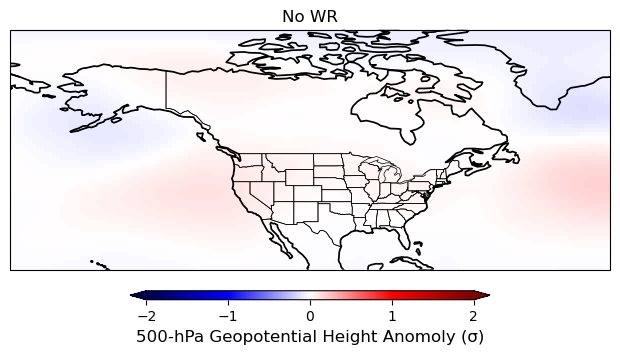

In [30]:
# Set up our figure
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6, 3))

ax1 = fig.add_axes([0, 0., 1., 1.], projection=proj)

im = ax1.pcolormesh(
    lons, lats, regime_mean, vmin=-2, vmax=2, 
    cmap='seismic', 
    shading='nearest', transform=ccrs.PlateCarree()
)
ax1.set_title(f'{wrtitle[wr]}', fontsize=12)
ax1.set_extent([-180, -30, 20, 80], crs=proj)
ax1.coastlines(resolution='110m', color='k', linewidth=1.25, zorder=10)
ax1.margins(x=0, y=0)
ax1.add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.5, zorder=10)
ax1.add_feature(cf.BORDERS, linewidth=0.5, zorder=10)

# Colorbar
cbar_ax = fig.add_axes([0.2, 0, 0.6, 0.03])
cb = plt.colorbar(im, location='bottom', orientation='horizontal', extend='both', cax=cbar_ax)
cb.set_label('500-hPa Geopotential Height Anomoly (\u03C3)', loc='center', fontsize=12)

plt.savefig(f'WR_{wr}.png', bbox_inches='tight')
plt.show()